In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from logger import logger
%matplotlib inline

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

import numpy as np
import warnings

from keras.layers import merge, Input
from keras.layers import Dense, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.layers import BatchNormalization
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file
from imagenet_utils import decode_predictions, preprocess_input

Using Theano backend.


In [3]:
# current_dir = '../data/images/train'
# new_dir = '../data/images/all_images'

### Copy  to single directory

In [4]:
def copy_to_single_dir(current_dir, image_dir):
    images_copied = 0

    for image_dir in os.listdir(current_dir):
        if not image_dir.startswith('.'):
            image_paths = os.listdir(os.path.join(current_dir, image_dir))
            image_count = len(image_paths)

            logger.info('{}: {} being copied'.format(image_dir, image_count))

            for image in image_paths:
                if not image.startswith('.'):
                    original_image_path = os.path.join(current_dir, image_dir, image)
                    new_image_path = os.path.join(new_dir, image)
                    shutil.copy(original_image_path, new_image_path)

            images_copied += image_count        
            logger.info('{} images copied so far'.format(images_copied))

In [5]:
# copy_to_single_dir(current_dir, new_dir)

### Create df of  image and bottleneck

In [27]:
train_dir = '../data/images_sample/train_top_level/test/Toys & Games/'
train_dir_above = '../data/images_sample/train_top_level/test/'

In [28]:
image_names = [image_name for image_name in os.listdir(train_dir) if not image_name.startswith('.')]
image_count = len(image_names)
img_width = 224
img_height = 224

In [29]:
def create_image_dict(image_names):
    image_dict = dict()
    
    for i, image_name in enumerate(image_names):
        image_dict[i] = image_name
        
    return image_dict

In [30]:
image_dict = create_image_dict(image_names)

In [31]:
image_dict

{0: 'B00GDGM61G.jpg',
 1: 'B00GDIOWFW.jpg',
 2: 'B00GF7MVS6.jpg',
 3: 'B00GH0T1KM.jpg',
 4: 'B00GHUH93S.jpg',
 5: 'B00GKT27S8.jpg',
 6: 'B00GLYWI0E.jpg',
 7: 'B00GLZR92A.jpg',
 8: 'B00GM01YNE.jpg',
 9: 'B00GM1ECLE.jpg',
 10: 'B00GM1KJLG.jpg',
 11: 'B00GM4JGHG.jpg',
 12: 'B00GODKQ2O.jpg',
 13: 'B00GOHYWKW.jpg',
 14: 'B00GSQ2BX4.jpg',
 15: 'B00GSQXNIG.jpg',
 16: 'B00GSWFQBM.jpg',
 17: 'B00GSXHADS.jpg',
 18: 'B00GSZJ5WK.jpg',
 19: 'B00GT2VMAU.jpg',
 20: 'B00GTDYEDQ.jpg',
 21: 'B00GVGIICE.jpg',
 22: 'B00H14UHSS.jpg',
 23: 'B00H2BZHF8.jpg',
 24: 'B00H3FJKMY.jpg',
 25: 'B00HCO4ILY.jpg',
 26: 'B00HCP0VTQ.jpg',
 27: 'B00HCP29GO.jpg',
 28: 'B00HCP4ZHU.jpg',
 29: 'B00HEPDC0Y.jpg',
 30: 'B00HH1KMPI.jpg',
 31: 'B00HQHBRQG.jpg',
 32: 'B00HRJCH4Y.jpg',
 33: 'B00HRJPT1M.jpg',
 34: 'B00I0LT89U.jpg',
 35: 'B00I3VWMP4.jpg',
 36: 'B00ICAKJJW.jpg',
 37: 'B00IHZZOCO.jpg',
 38: 'B00II5G67K.jpg',
 39: 'B00IK54FNA.jpg',
 40: 'B00IOBIA9K.jpg',
 41: 'B00IUPZ5Y8.jpg',
 42: 'B00IVDVWSM.jpg',
 43: 'B00IVDVWVO.jpg'

In [32]:
def largest_divisor(n, threshold=100):
    factors_set = set(reduce(list.__add__, ([i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0)))
    factors_list = [i for i in factors_set if i <= threshold]
    factors_list.sort()
    return factors_list[-1]

In [33]:
# Load Data Genenerator
def load_data_generator():
    datagen = ImageDataGenerator(rescale=1./255)
    return datagen

In [34]:
datagen = load_data_generator()

In [36]:
generator = datagen.flow_from_directory(train_dir_above, 
                                        target_size=(img_width, img_height), 
                                        batch_size=largest_divisor(image_count), 
                                        class_mode=None, 
                                        shuffle=False, 
                                        seed=1368)

Found 52 images belonging to 1 classes.


In [40]:
# model = ResNet50(include_top=False, weights='imagenet', input_tensor=None)
model = VGG16(include_top=False, weights='imagenet', input_tensor=None)

('K.image_dim_ordering:', 'th')


In [41]:
# bottleneck_feats = model.predict_generator(generator, 1, max_q_size=20, nb_worker=4)
# np.save(open(train_dir + 'model/' + 'bottleneck_features.npy', 'w'), bottleneck_feats)

In [42]:
bottleneck_feats = model.predict_generator(generator, generator.nb_sample, max_q_size=20, nb_worker=4)
np.save(open(train_dir_above + 'model/' + 'bottleneck_features.npy', 'w'), bottleneck_feats)

IOError: [Errno 2] No such file or directory: '../data/images_sample/train_top_level/test/model/bottleneck_features.npy'

In [43]:
bottleneck_feats.shape

(52, 25088)

In [44]:
bottleneck_feats

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          1.49011612e-08,   1.49011612e-08,   1.49011612e-08],
       [  1.23195760e-01,   0.00000000e+00,   0.00000000e+00, ...,
          1.49011612e-08,   1.49011612e-08,   1.49011612e-08],
       [  7.24553019e-02,   0.00000000e+00,   0.00000000e+00, ...,
          1.49011612e-08,   1.49011612e-08,   1.49011612e-08],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          1.49011612e-08,   1.49011612e-08,   1.49011612e-08],
       [  3.04149240e-02,   0.00000000e+00,   0.00000000e+00, ...,
          1.49011612e-08,   1.49011612e-08,   1.49011612e-08],
       [  1.84327513e-01,   0.00000000e+00,   0.00000000e+00, ...,
          1.49011612e-08,   1.49011612e-08,   1.49011612e-08]], dtype=float32)

In [45]:
def cosine_similarity(bottleneck_features):
    csim = bottleneck_features.dot(bottleneck_features.T)
    if not isinstance(csim, np.ndarray):
        csim = csim.toarray()
    norms = np.array([np.sqrt(np.diagonal(csim))])
    return (csim / norms / norms.T)

In [46]:
csim = cosine_similarity(bottleneck_feats)

In [47]:
# csim_index = [range(len(csim))]
# csim = np.insert(csim, 0, csim_index, axis=1)

In [48]:
# filter_indices=[10,11,12,13,14,15,16,17,18,19,20,21,22,23]

In [49]:
# csim = csim[filter_indices]

0 B00GDGM61G.jpg


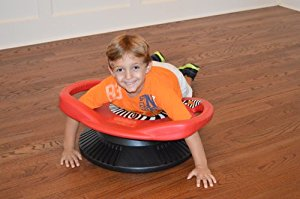

In [52]:
image_idx = 0
image_name = image_dict[image_idx]
print image_idx, image_name
Image(train_dir + image_name)

In [53]:
# csim[image_idx].argsort()

In [55]:
np.argsort(-csim[image_idx])[:5]

array([ 0, 16,  4, 17, 25])

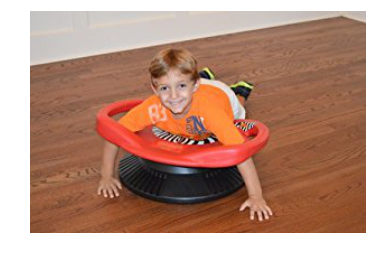

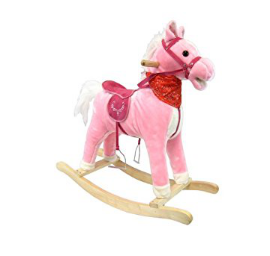

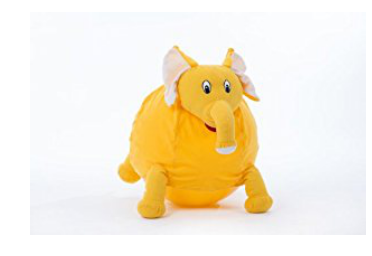

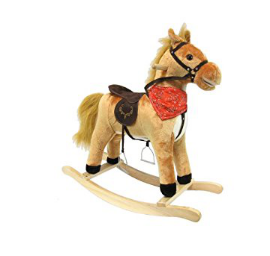

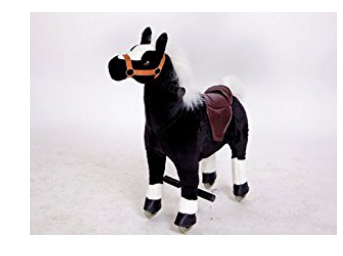

In [54]:
most_similar = np.argsort(-csim[image_idx])[:5]

for i in most_similar:
    image_name = image_dict[i]
    image_display = plt.imread(train_dir + image_name)
    plt.axis('off')
    plt.imshow(image_display.astype('uint8'))
    plt.figure()

### To Do
- How to featurize new search image and calculate cosine similiarity?
- How to filter by category?

### Resnet model

In [140]:
TH_WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_th_dim_ordering_th_kernels.h5'
TF_WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels.h5'
TH_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_th_dim_ordering_th_kernels_notop.h5'
TF_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'


def identity_block(input_tensor, kernel_size, filters, stage, block):
    '''The identity_block is the block that has no conv layer at shortcut

    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    '''
    nb_filter1, nb_filter2, nb_filter3 = filters
    if K.image_dim_ordering() == 'tf':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Convolution2D(nb_filter1, 1, 1, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter2, kernel_size, kernel_size,
                      border_mode='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter3, 1, 1, name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = merge([x, input_tensor], mode='sum')
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    '''conv_block is the block that has a conv layer at shortcut

    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names

    Note that from stage 3, the first conv layer at main path is with subsample=(2,2)
    And the shortcut should have subsample=(2,2) as well
    '''
    nb_filter1, nb_filter2, nb_filter3 = filters
    if K.image_dim_ordering() == 'tf':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Convolution2D(nb_filter1, 1, 1, subsample=strides,
                      name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter2, kernel_size, kernel_size, border_mode='same',
                      name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter3, 1, 1, name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Convolution2D(nb_filter3, 1, 1, subsample=strides,
                             name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = merge([x, shortcut], mode='sum')
    x = Activation('relu')(x)
    return x


def ResNet50(include_top=True, weights='imagenet',
             input_tensor=None):
    '''Instantiate the ResNet50 architecture,
    optionally loading weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_dim_ordering="tf"` in your Keras config
    at ~/.keras/keras.json.

    The model and the weights are compatible with both
    TensorFlow and Theano. The dimension ordering
    convention used by the model is the one
    specified in your Keras config file.

    # Arguments
        include_top: whether to include the 3 fully-connected
            layers at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. xput of `layers.Input()`)
            to use as image input for the model.

    # Returns
        A Keras model instance.
    '''
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')
    # Determine proper input shape
    if K.image_dim_ordering() == 'th':
        if include_top:
            input_shape = (3, 224, 224)
        else:
            input_shape = (3, 224, 224)
    else:
        if include_top:
            input_shape = (224, 224, 3)
        else:
            input_shape = (224, 224, 3)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor)
        else:
            img_input = input_tensor
    if K.image_dim_ordering() == 'tf':
        bn_axis = 3
    else:
        bn_axis = 1

    x = ZeroPadding2D((3, 3))(img_input)
    x = Convolution2D(64, 7, 7, subsample=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    x = AveragePooling2D((7, 7), name='avg_pool')(x)
    
    x = Flatten()(x)

    if include_top:
        x = Flatten()(x)
        x = Dense(1000, activation='softmax', name='fc1000')(x)

    model = Model(img_input, x)

    # load weights
    if weights == 'imagenet':
        print('K.image_dim_ordering:', K.image_dim_ordering())
        if K.image_dim_ordering() == 'th':
            if include_top:
                weights_path = get_file('resnet50_weights_th_dim_ordering_th_kernels.h5',
                                        TH_WEIGHTS_PATH,
                                        cache_subdir='models',
                                        md5_hash='1c1f8f5b0c8ee28fe9d950625a230e1c')
            else:
                weights_path = get_file('resnet50_weights_th_dim_ordering_th_kernels_notop.h5',
                                        TH_WEIGHTS_PATH_NO_TOP,
                                        cache_subdir='models',
                                        md5_hash='f64f049c92468c9affcd44b0976cdafe')
            model.load_weights(weights_path)
            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image dimension ordering convention '
                              '(`image_dim_ordering="th"`). '
                              'For best performance, set '
                              '`image_dim_ordering="tf"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
                convert_all_kernels_in_model(model)
        else:
            if include_top:
                weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels.h5',
                                        TF_WEIGHTS_PATH,
                                        cache_subdir='models',
                                        md5_hash='a7b3fe01876f51b976af0dea6bc144eb')
            else:
                weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                        TF_WEIGHTS_PATH_NO_TOP,
                                        cache_subdir='models',
                                        md5_hash='a268eb855778b3df3c7506639542a6af')
            model.load_weights(weights_path)
            if K.backend() == 'theano':
                convert_all_kernels_in_model(model)
    return model

In [ ]:
TH_WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/inception_v3_weights_th_dim_ordering_th_kernels.h5'
TF_WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/inception_v3_weights_tf_dim_ordering_tf_kernels.h5'
TH_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/inception_v3_weights_th_dim_ordering_th_kernels_notop.h5'
TF_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'


def conv2d_bn(x, nb_filter, nb_row, nb_col,
              border_mode='same', subsample=(1, 1),
              name=None):
    '''
    Utility function to apply conv + BN.
    '''
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
    if K.image_dim_ordering() == 'th':
        bn_axis = 1
    else:
        bn_axis = 3
    x = Convolution2D(nb_filter, nb_row, nb_col,
                      subsample=subsample,
                      activation='relu',
                      border_mode=border_mode,
                      name=conv_name)(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name)(x)
    return x


def InceptionV3(include_top=True, weights='imagenet',
                input_tensor=None):
    '''Instantiate the Inception v3 architecture,
    optionally loading weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_dim_ordering="tf"` in your Keras config
    at ~/.keras/keras.json.

    The model and the weights are compatible with both
    TensorFlow and Theano. The dimension ordering
    convention used by the model is the one
    specified in your Keras config file.

    Note that the default input image size for this model is 299x299.

    # Arguments
        include_top: whether to include the 3 fully-connected
            layers at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.

    # Returns
        A Keras model instance.
    '''
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')
    # Determine proper input shape
    if K.image_dim_ordering() == 'th':
        if include_top:
            input_shape = (3, 299, 299)
        else:
            input_shape = (3, 299, 299)
    else:
        if include_top:
            input_shape = (299, 299, 3)
        else:
            input_shape = (299, 299, 3)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor)
        else:
            img_input = input_tensor

    if K.image_dim_ordering() == 'th':
        channel_axis = 1
    else:
        channel_axis = 3

    x = conv2d_bn(img_input, 32, 3, 3, subsample=(2, 2), border_mode='valid')
    # with stride=2 border='valid', output becomes (299-1)/2 = 149 x 149
    x = conv2d_bn(x, 32, 3, 3, border_mode='valid')  # 149 - 2 = 147 x 147
    x = conv2d_bn(x, 64, 3, 3)  # 147 x 147
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)  # 49

    x = conv2d_bn(x, 80, 1, 1, border_mode='valid')
    x = conv2d_bn(x, 192, 3, 3, border_mode='valid')
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    # mixed 0, 1, 2: 35 x 35 x 256
    for i in range(3):
        branch1x1 = conv2d_bn(x, 64, 1, 1)

        branch5x5 = conv2d_bn(x, 48, 1, 1)
        branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

        branch3x3dbl = conv2d_bn(x, 64, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

        branch_pool = AveragePooling2D(
            (3, 3), strides=(1, 1), border_mode='same')(x)
        branch_pool = conv2d_bn(branch_pool, 32, 1, 1)
        x = merge([branch1x1, branch5x5, branch3x3dbl, branch_pool],
                  mode='concat', concat_axis=channel_axis,
                  name='mixed' + str(i))

    # mixed 3: 17 x 17 x 768
    branch3x3 = conv2d_bn(x, 384, 3, 3, subsample=(2, 2), border_mode='valid')

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3,
                             subsample=(2, 2), border_mode='valid')

    branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = merge([branch3x3, branch3x3dbl, branch_pool],
              mode='concat', concat_axis=channel_axis,
              name='mixed3')

    # mixed 4: 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 128, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 128, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 128, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), border_mode='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = merge([branch1x1, branch7x7, branch7x7dbl, branch_pool],
              mode='concat', concat_axis=channel_axis,
              name='mixed4')

    # mixed 5, 6: 17 x 17 x 768
    for i in range(2):
        branch1x1 = conv2d_bn(x, 192, 1, 1)

        branch7x7 = conv2d_bn(x, 160, 1, 1)
        branch7x7 = conv2d_bn(branch7x7, 160, 1, 7)
        branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

        branch7x7dbl = conv2d_bn(x, 160, 1, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 1, 7)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

        branch_pool = AveragePooling2D(
            (3, 3), strides=(1, 1), border_mode='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = merge([branch1x1, branch7x7, branch7x7dbl, branch_pool],
                  mode='concat', concat_axis=channel_axis,
                  name='mixed' + str(5 + i))

    # mixed 7: 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 192, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 192, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 160, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), border_mode='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = merge([branch1x1, branch7x7, branch7x7dbl, branch_pool],
              mode='concat', concat_axis=channel_axis,
              name='mixed7')

    # mixed 8: 8 x 8 x 1280
    branch3x3 = conv2d_bn(x, 192, 1, 1)
    branch3x3 = conv2d_bn(branch3x3, 320, 3, 3,
                          subsample=(2, 2), border_mode='valid')

    branch7x7x3 = conv2d_bn(x, 192, 1, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 1, 7)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 7, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 3, 3,
                            subsample=(2, 2), border_mode='valid')

    branch_pool = AveragePooling2D((3, 3), strides=(2, 2))(x)
    x = merge([branch3x3, branch7x7x3, branch_pool],
              mode='concat', concat_axis=channel_axis,
              name='mixed8')

    # mixed 9: 8 x 8 x 2048
    for i in range(2):
        branch1x1 = conv2d_bn(x, 320, 1, 1)

        branch3x3 = conv2d_bn(x, 384, 1, 1)
        branch3x3_1 = conv2d_bn(branch3x3, 384, 1, 3)
        branch3x3_2 = conv2d_bn(branch3x3, 384, 3, 1)
        branch3x3 = merge([branch3x3_1, branch3x3_2],
                          mode='concat', concat_axis=channel_axis,
                          name='mixed9_' + str(i))

        branch3x3dbl = conv2d_bn(x, 448, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 384, 3, 3)
        branch3x3dbl_1 = conv2d_bn(branch3x3dbl, 384, 1, 3)
        branch3x3dbl_2 = conv2d_bn(branch3x3dbl, 384, 3, 1)
        branch3x3dbl = merge([branch3x3dbl_1, branch3x3dbl_2],
                             mode='concat', concat_axis=channel_axis)

        branch_pool = AveragePooling2D(
            (3, 3), strides=(1, 1), border_mode='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = merge([branch1x1, branch3x3, branch3x3dbl, branch_pool],
                  mode='concat', concat_axis=channel_axis,
                  name='mixed' + str(9 + i))

    x = AveragePooling2D((8, 8), strides=(8, 8), name='avg_pool')(x)  # Moved here for transfer learning

    if include_top:
        # Classification block
        # x = AveragePooling2D((8, 8), strides=(8, 8), name='avg_pool')(x)
        x = Flatten(name='flatten')(x)
        x = Dense(1000, activation='softmax', name='predictions')(x)

    # Create model
    model = Model(img_input, x)

    # load weights
    if weights == 'imagenet':
        if K.image_dim_ordering() == 'th':
            if include_top:
                weights_path = get_file('inception_v3_weights_th_dim_ordering_th_kernels.h5',
                                        TH_WEIGHTS_PATH,
                                        cache_subdir='models',
                                        md5_hash='b3baf3070cc4bf476d43a2ea61b0ca5f')
            else:
                weights_path = get_file('inception_v3_weights_th_dim_ordering_th_kernels_notop.h5',
                                        TH_WEIGHTS_PATH_NO_TOP,
                                        cache_subdir='models',
                                        md5_hash='79aaa90ab4372b4593ba3df64e142f05')
            model.load_weights(weights_path)
            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image dimension ordering convention '
                              '(`image_dim_ordering="th"`). '
                              'For best performance, set '
                              '`image_dim_ordering="tf"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
                convert_all_kernels_in_model(model)
        else:
            if include_top:
                weights_path = get_file('inception_v3_weights_tf_dim_ordering_tf_kernels.h5',
                                        TF_WEIGHTS_PATH,
                                        cache_subdir='models',
                                        md5_hash='fe114b3ff2ea4bf891e9353d1bbfb32f')
            else:
                weights_path = get_file('inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                        TF_WEIGHTS_PATH_NO_TOP,
                                        cache_subdir='models',
                                        md5_hash='2f3609166de1d967d1a481094754f691')
            model.load_weights(weights_path)
            if K.backend() == 'theano':
                convert_all_kernels_in_model(model)
    return model

In [38]:
TH_WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_th_dim_ordering_th_kernels.h5'
TF_WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
TH_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_th_dim_ordering_th_kernels_notop.h5'
TF_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'


def VGG16(include_top=True, weights='imagenet',
          input_tensor=None):
    '''Instantiate the VGG16 architecture,
    optionally loading weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_dim_ordering="tf"` in your Keras config
    at ~/.keras/keras.json.

    The model and the weights are compatible with both
    TensorFlow and Theano. The dimension ordering
    convention used by the model is the one
    specified in your Keras config file.

    # Arguments
        include_top: whether to include the 3 fully-connected
            layers at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.

    # Returns
        A Keras model instance.
    '''
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    # Determine proper input shape
    if K.image_dim_ordering() == 'th':
        if include_top:
            input_shape = (3, 224, 224)
        else:
            input_shape = (3, 224, 224)
    else:
        if include_top:
            input_shape = (224, 224, 3)
        else:
            input_shape = (224, 224, 3)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor)
        else:
            img_input = input_tensor

    # Block 1
    x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1')(img_input)
    x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv1')(x)
    x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv1')(x)
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv2')(x)
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv1')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv2')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv1')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv2')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    
    x = Flatten(name='flatten')(x)  # Add flattern

    if include_top:
        # Classification block
        # x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(1000, activation='softmax', name='predictions')(x)

    # Create model
    model = Model(img_input, x)

    # load weights
    if weights == 'imagenet':
        print('K.image_dim_ordering:', K.image_dim_ordering())
        if K.image_dim_ordering() == 'th':
            if include_top:
                weights_path = get_file('vgg16_weights_th_dim_ordering_th_kernels.h5',
                                        TH_WEIGHTS_PATH,
                                        cache_subdir='models')
            else:
                weights_path = get_file('vgg16_weights_th_dim_ordering_th_kernels_notop.h5',
                                        TH_WEIGHTS_PATH_NO_TOP,
                                        cache_subdir='models')
            model.load_weights(weights_path)
            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image dimension ordering convention '
                              '(`image_dim_ordering="th"`). '
                              'For best performance, set '
                              '`image_dim_ordering="tf"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
                convert_all_kernels_in_model(model)
        else:
            if include_top:
                weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels.h5',
                                        TF_WEIGHTS_PATH,
                                        cache_subdir='models')
            else:
                weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                        TF_WEIGHTS_PATH_NO_TOP,
                                        cache_subdir='models')
            model.load_weights(weights_path)
            if K.backend() == 'theano':
                convert_all_kernels_in_model(model)
    return model

### Understanding InceptionV3 architecture

In [ ]:
from keras.models import Sequential

In [ ]:
def conv2d_bn(x, nb_filter, nb_row, nb_col,
              border_mode='same', subsample=(1, 1),
              name=None):
    '''
    Utility function to apply conv + BN.
    '''
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
    if K.image_dim_ordering() == 'th':
        bn_axis = 1
    else:
        bn_axis = 3
    x = Convolution2D(nb_filter, nb_row, nb_col,
                      subsample=subsample,
                      activation='relu',
                      border_mode=border_mode,
                      name=conv_name)(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name)(x)
    return x



In [ ]:
img_input = Input(shape=(3, 299, 299))

In [ ]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, subsample=(2, 2), border_mode='valid', input_shape=(3, 299, 299)))
model.output_shape

In [ ]:
model.add(Convolution2D(32, 3, 3, border_mode='valid'))
model.output_shape

In [ ]:
model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.output_shape

In [ ]:
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.output_shape

In [ ]:
model.add(Convolution2D(80, 1, 1, border_mode='valid'))
model.output_shape

In [ ]:
model.add(Convolution2D(192, 3, 3, border_mode='valid'))
model.output_shape

In [ ]:
model.add(MaxPooling2D((3, 3), strides=(2, 2)))
model.output_shape

In [ ]:
x = conv2d_bn(img_input, 32, 3, 3, subsample=(2, 2), border_mode='valid')
# with stride=2 border='valid', output becomes (299-1)/2 = 149 x 149
x = conv2d_bn(x, 32, 3, 3, border_mode='valid')  # 149 - 2 = 147 x 147
x = conv2d_bn(x, 64, 3, 3)  # 147 x 147
x = MaxPooling2D((3, 3), strides=(2, 2))(x)  # 49

x = conv2d_bn(x, 80, 1, 1, border_mode='valid')
x = conv2d_bn(x, 192, 3, 3, border_mode='valid')
x = MaxPooling2D((3, 3), strides=(2, 2))(x)